In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

import copy

from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('data.csv')
df.shape


(288, 7)

In [3]:
columns = list(df.columns)
columns

['index',
 'totalCarNumber',
 'numberOfTrips',
 'median_overhead',
 'q1_overhead',
 'q3_overhead',
 'p9_overhead']

In [4]:
df_before =df.iloc[:144, :]


indexes = np.array_split(df_before.index,8, axis=0)
for i,index in enumerate(indexes):
    df_before.loc[index,'group'] = i
    
df_before['c'] = df_before['group'].diff()
df_filtered = df_before[df_before['c'] != 0]

index_list = df_filtered.index.tolist() # list of the start poisitions of index for change of values 
# print(len(index_list))
# print('\n')
# print(index_list)

l_mod = index_list + [max(index_list)+1] # creating a list of indexes to iterate over (must have 0 in it)
list_of_dfs = [df_before.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)] # creating a list of dfs for each index

# len(list_of_dfs)

/home/marta/env/lib/python3.6/site-packages/pandas-1.0.3-py3.6-linux-x86_64.egg/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/marta/env/lib/python3.6/site-packages/pandas-1.0.3-py3.6-linux-x86_64.egg/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [5]:
def plot_silhouette_scores(model, test_data, n_clusters_min, n_clusters_max, title):
    """ Plot silhouette scores and return the best number of clusters"""

    if len(model.subcluster_labels_) >= 2:

        silhouette_scores = []

        clusters_range = range(n_clusters_min, n_clusters_max+1)
        results_dict = []
        # print(clusters_range)
        for number in clusters_range:
            # make a copy of the model so as not to mess up the 'correct' model
            model_cpy = copy.deepcopy(model)
            model_cpy.set_params(n_clusters=number)

            model_cpy.partial_fit()
            labels = model_cpy.predict(test_data)
            # print(labels)
            try: 
                s = metrics.silhouette_score(test_data, labels, metric='euclidean')
                silhouette_scores.append(s)
                results_dict.append((number, s))
            except ValueError:
                pass

        silhouette_range = [i[0] for i in results_dict]  
#         plt.plot(silhouette_range[:], silhouette_scores[:], label = title)
#         plt.xlabel('Number of Clusters')
#         plt.ylabel('Silhouette Score')
#         plt.title(title)
#         plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
#         plt.savefig(folder + 'silhouette_'+ save_graph_name +'.png')
#         plt.show()
#         plt.close() 
        max_score = max(silhouette_scores)
#         print(results_dict)
        for i in results_dict:
            if i[1] == max_score:
                print("The highest silhouette scores(" + str(max_score) + ") is for " + str(i[0]) + " clusers")
                return int(i[0])
    else:
        print('couldnt get the scores, plz help')
        print('returning number of clusters = ' + str(n_clusters_min))
#         model_cpy = copy.deepcopy(model)
#         model_cpy.set_params(n_clusters=2)

#         model_cpy.partial_fit()
#         labels = model_cpy.predict(test_data)
#         s = metrics.silhouette_score(test_data, labels, metric='euclidean')
#         print(s)
#         print('\n')
        return n_clusters_min

In [6]:
def combine_dfs(df_list):
    return pd.concat(df_list)

In [7]:
def outliers_removal(df):
    data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
    # to_drop = [252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,265,266]
    # data_split_modified_z.drop(to_drop, inplace=True)
#     data_split_modified_z = data_split_modified_z.iloc[:144, :]
    data_split_modified_z = data_split_modified_z.to_numpy()
    data_split_modified_z_12 = np.split(data_split_modified_z, 1)
    indexes = [] 

    for d in range(len(data_split_modified_z_12)):
        ind = []
        k = len(data_split_modified_z_12[d])
        for i in [0, 1, 2, 3]:
            ys = data_split_modified_z_12[d][:,i] 
            median_y = np.median(ys)
            median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    #         print(median_absolute_deviation_y)
            for y in range(len(data_split_modified_z_12[d])):
                modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
    #             z_score = (data_split[d][y, i]  - mean_ys) / std_ys
                if np.abs(modified_z_score) > 3.5:
                    ind.append(y)


        data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)
        print('Outliers detected: ' + str((k - len(data_split_modified_z_12[d]))))

    data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)
    return data_split_modified_z_12

# a day of data (no accident)

In [8]:
model_005_before= Birch(n_clusters=None, threshold=0.05)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)


In [9]:
fit_number = 1

list_of_dfs

for i in range(0, len(list_of_dfs)):
#     add_data_to_this = pd.concat([add_data_to_this, i])
    print(f'fit number: {fit_number}')

    numpy_array = outliers_removal(list_of_dfs[i])
    
    model_005_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_005_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, 'threshold 0.05')
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (8) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (8) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


fit number: 1
Outliers detected: 0
The highest silhouette scores(0.6096400544974454) is for 2 clusers
fit number: 2
Outliers detected: 0
The highest silhouette scores(0.597601321910315) is for 2 clusers
fit number: 3
Outliers detected: 2
The highest silhouette scores(0.6651896639224805) is for 2 clusers
fit number: 4
Outliers detected: 0
The highest silhouette scores(0.6832618553993948) is for 2 clusers
fit number: 5
Outliers detected: 0
The highest silhouette scores(0.6849089708667776) is for 2 clusers
fit number: 6
Outliers detected: 5
The highest silhouette scores(0.6916074073004109) is for 2 clusers
fit number: 7
Outliers detected: 0
The highest silhouette scores(0.6507942452061477) is for 2 clusers
fit number: 8
Outliers detected: 0
The highest silhouette scores(0.6530217970537068) is for 2 clusers


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [10]:
len(labels_dict)

8

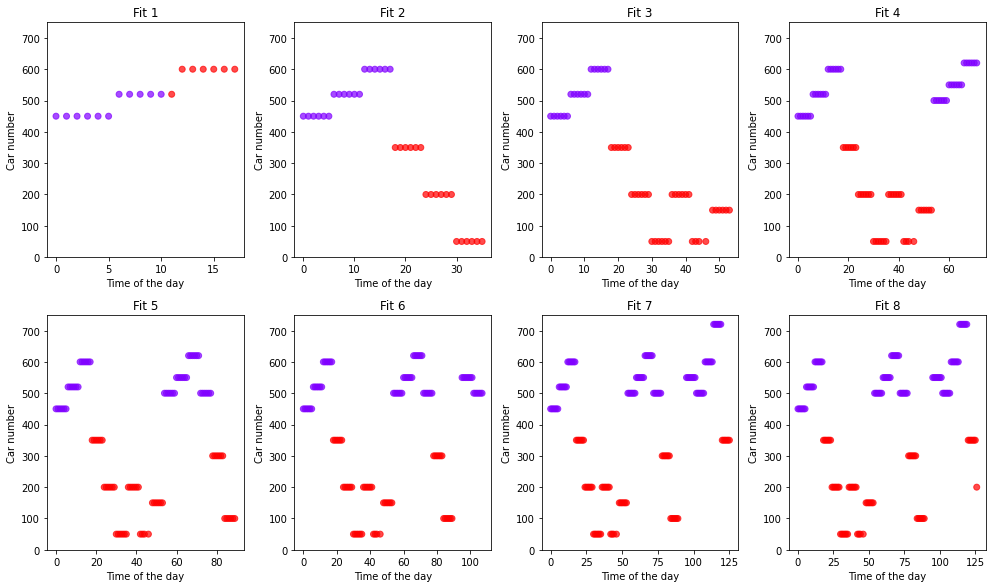

In [11]:
col_counter = 0
row_counter = 0

fit_number = 1

nrows = 2
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14,9))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
#     if fit_number >= 9:
#         axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

---
# whole two days of data
## day one - normal traffic 
## day two - accident

In [12]:
indexes = np.array_split(df.index,16, axis=0)
for i,index in enumerate(indexes):
    df.loc[index,'group'] = i
    
df['c'] = df['group'].diff()
df_filtered = df[df['c'] != 0]

index_list = df_filtered.index.tolist() # list of the start poisitions of index for change of values 
print(len(index_list))
print('\n')
print(index_list)

l_mod = index_list + [max(index_list)+1] # creating a list of indexes to iterate over (must have 0 in it)
list_of_dfs = [df.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)] # creating a list of dfs for each index

len(list_of_dfs)

16


[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180, 198, 216, 234, 252, 270]


16

# THIS IS THE CORRECT SHIT 

In [13]:
##########################################################
###############     THRESHOLD 0.01       #################
##########################################################


model_001_whole = Birch(n_clusters=None, threshold=0.01)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_001_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.01')
n = plot_silhouette_scores(model_001_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.5')
model_001_whole.set_params(n_clusters = n)
model_001_whole.partial_fit()

lablels_001 = model_001_whole.predict(new_nmpy[:, :-2])

##########################################################
###############     THRESHOLD 0.05      #################
##########################################################


model_005_whole = Birch(n_clusters=None, threshold=0.05)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_005_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.05')
n = plot_silhouette_scores(model_005_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.5')
model_005_whole.set_params(n_clusters = n)
model_005_whole.partial_fit()

lablels_005 = model_005_whole.predict(new_nmpy[:, :-2])

##########################################################
###############     THRESHOLD 0.1       #################
##########################################################


model_01_whole = Birch(n_clusters=None, threshold=0.1)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_01_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.1')
n = plot_silhouette_scores(model_01_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.5')
model_01_whole.set_params(n_clusters = n)
model_01_whole.partial_fit()

lablels_01 = model_01_whole.predict(new_nmpy[:, :-2])


##########################################################
###############     THRESHOLD 0.2       #################
##########################################################


model_02_whole = Birch(n_clusters=None, threshold=0.2)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_02_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.1')
n = plot_silhouette_scores(model_02_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.5')
model_02_whole.set_params(n_clusters = n)
model_02_whole.partial_fit()

lablels_02 = model_02_whole.predict(new_nmpy[:, :-2])


##########################################################
###############     THRESHOLD 0.3      #################
##########################################################



model_03_whole = Birch(n_clusters=None, threshold=0.3)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_03_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.3')
n = plot_silhouette_scores(model_03_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.3')
model_03_whole.set_params(n_clusters = n)
model_03_whole.partial_fit()

lablels_03 = model_03_whole.predict(new_nmpy[:, :-2])

##########################################################
###############     THRESHOLD 0.5      #################
##########################################################

model_05_whole = Birch(n_clusters=None, threshold=0.5)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_05_whole.partial_fit(numpy_array[:, :-2])
    
print('THRESHOLD 0.5')
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
n = plot_silhouette_scores(model_05_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.5')
model_05_whole.set_params(n_clusters = n)
model_05_whole.partial_fit()

lablels_05 = model_05_whole.predict(new_nmpy[:, :-2])

Outliers detected: 0
Outliers detected: 0
Outliers detected: 2
Outliers detected: 0
Outliers detected: 0
Outliers detected: 5
Outliers detected: 0
Outliers detected: 1
Outliers detected: 2
Outliers detected: 2
Outliers detected: 4
Outliers detected: 2
Outliers detected: 3
Outliers detected: 0
Outliers detected: 4
Outliers detected: 0
THRESHOLD 0.01
The highest silhouette scores(0.8753582274223032) is for 2 clusers
Outliers detected: 0
Outliers detected: 0
Outliers detected: 2
Outliers detected: 0
Outliers detected: 0


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


Outliers detected: 5
Outliers detected: 0
Outliers detected: 1
Outliers detected: 2
Outliers detected: 2
Outliers detected: 4
Outliers detected: 2
Outliers detected: 3
Outliers detected: 0
Outliers detected: 4
Outliers detected: 0
THRESHOLD 0.05
The highest silhouette scores(0.8753582274223032) is for 2 clusers
Outliers detected: 0
Outliers detected: 0
Outliers detected: 2
Outliers detected: 0
Outliers detected: 0
Outliers detected: 5
Outliers detected: 0
Outliers detected: 1
Outliers detected: 2
Outliers detected: 2
Outliers detected: 4
Outliers detected: 2
Outliers detected: 3
Outliers detected: 0
Outliers detected: 4
Outliers detected: 0
THRESHOLD 0.1


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


The highest silhouette scores(0.8753582274223032) is for 2 clusers
Outliers detected: 0
Outliers detected: 0
Outliers detected: 2
Outliers detected: 0
Outliers detected: 0
Outliers detected: 5
Outliers detected: 0
Outliers detected: 1
Outliers detected: 2
Outliers detected: 2
Outliers detected: 4
Outliers detected: 2
Outliers detected: 3
Outliers detected: 0
Outliers detected: 4
Outliers detected: 0
THRESHOLD 0.1
The highest silhouette scores(0.8753582274223032) is for 2 clusers
Outliers detected: 0
Outliers detected: 0
Outliers detected: 2
Outliers detected: 0
Outliers detected: 0
Outliers detected: 5
Outliers detected: 0
Outliers detected: 1
Outliers detected: 2
Outliers detected: 2
Outliers detected: 4
Outliers detected: 2
Outliers detected: 3
Outliers detected: 0
Outliers detected: 4
Outliers detected: 0
THRESHOLD 0.3
The highest silhouette scores(0.7685236997266502) is for 2 clusers
Outliers detected: 0
Outliers detected: 0
Outliers detected: 2
Outliers detected: 0
Outliers detect

/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [14]:
model_05_whole = Birch(n_clusters=None, threshold=0.5)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

new_nmpy = []

for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_05_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
n = plot_silhouette_scores(model_05_whole, new_nmpy[:, :-2], 2, 10, 'threshold 0.3')
model_05_whole.set_params(n_clusters = n)
model_05_whole.partial_fit()

lablels_05 = model_05_whole.predict(new_nmpy[:, :-2])

Outliers detected: 0
Outliers detected: 0
Outliers detected: 2
Outliers detected: 0
Outliers detected: 0
Outliers detected: 5
Outliers detected: 0
Outliers detected: 1
Outliers detected: 2
Outliers detected: 2
Outliers detected: 4
Outliers detected: 2
Outliers detected: 3
Outliers detected: 0
Outliers detected: 4
Outliers detected: 0
The highest silhouette scores(0.8753582274223032) is for 2 clusers


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


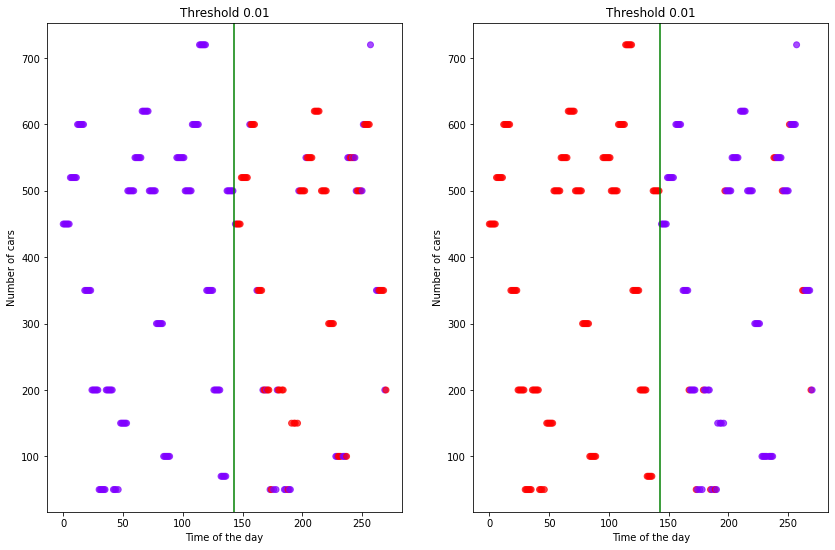

In [15]:
figure, axs = plt.subplots(nrows=1, ncols=2,figsize=(14,9))

axs[0].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_03, cmap='rainbow', alpha=0.7)
axs[0].axvline(x=143, color='g')
axs[0].set_ylabel('Number of cars')
axs[0].set_xlabel('Time of the day')
axs[0].title.set_text("Threshold 0.01")

axs[1].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_05, cmap='rainbow', alpha=0.7)
axs[1].axvline(x=143, color='g')
axs[1].set_ylabel('Number of cars')
axs[1].set_xlabel('Time of the day')
axs[1].title.set_text("Threshold 0.01")

In [16]:
model_005_whole = Birch(n_clusters=None, threshold=0.01)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

In [17]:
fit_number = 1

for i in range(0, len(list_of_dfs)):
#     add_data_to_this = pd.concat([add_data_to_this, i])
    print(f'fit number: {fit_number}')
    numpy_array = outliers_removal(list_of_dfs[i])
    removed_outliers_numpy.append(numpy_array)
    
    model_005_whole.partial_fit(numpy_array[:, :-2])
    model_copy = copy.deepcopy(model_005_whole)
    
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, 'threshold 0.05')
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

fit number: 1
Outliers detected: 0
The highest silhouette scores(0.625344950378112) is for 2 clusers
fit number: 2
Outliers detected: 0
The highest silhouette scores(0.597601321910315) is for 2 clusers
fit number: 3
Outliers detected: 2
The highest silhouette scores(0.5948310802120068) is for 3 clusers
fit number: 4
Outliers detected: 0
The highest silhouette scores(0.6390468476494574) is for 2 clusers
fit number: 5
Outliers detected: 0
The highest silhouette scores(0.6849089708667776) is for 2 clusers
fit number: 6
Outliers detected: 5
The highest silhouette scores(0.6916074073004109) is for 2 clusers
fit number: 7
Outliers detected: 0
The highest silhouette scores(0.6507942452061477) is for 2 clusers
fit number: 8
Outliers detected: 1
The highest silhouette scores(0.6718416730122099) is for 2 clusers
fit number: 9
Outliers detected: 2
The highest silhouette scores(0.9488405530064169) is for 2 clusers
fit number: 10
Outliers detected: 2
The highest silhouette scores(0.9276155870341334

/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


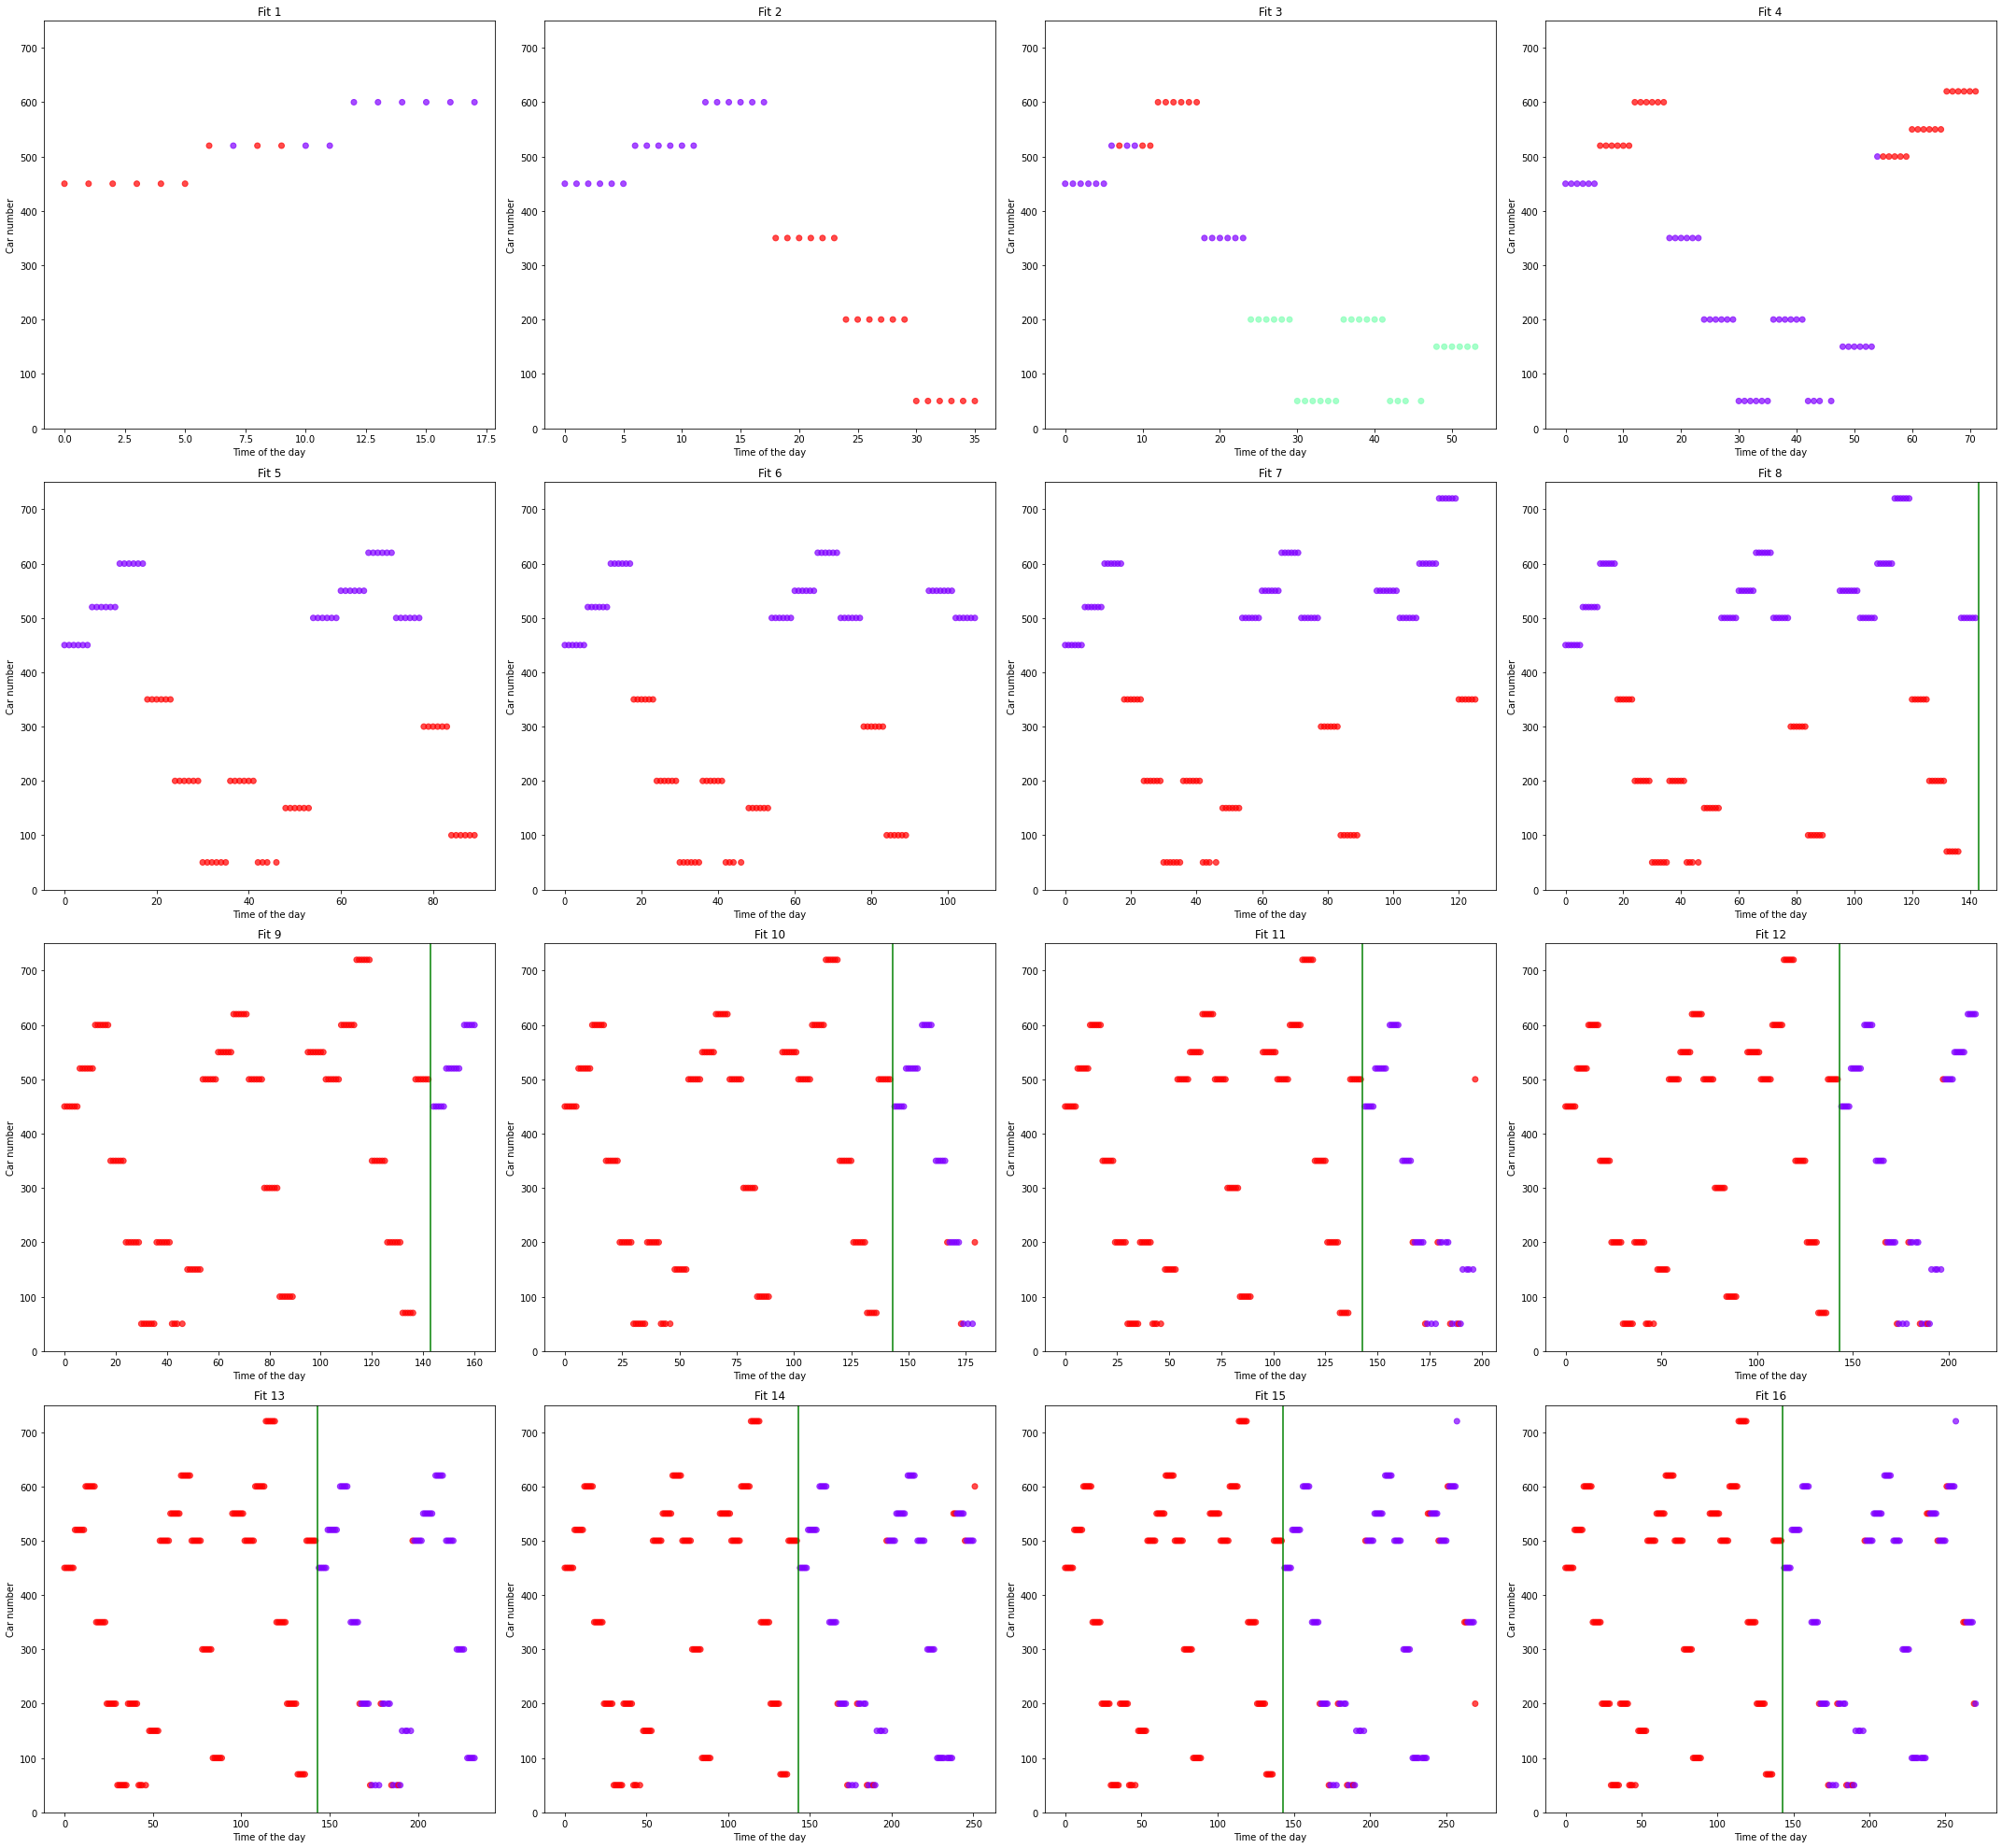

In [18]:
col_counter = 0
row_counter = 0

nrows = 4
ncols = 4

fit_number = 1

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(30,30))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
    if fit_number >= 8:
        axs[row_counter,col_counter].axvline(x=143, color='g')
    
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

Outliers detected: 0
couldnt get the scores, plz help
returning number of clusters = 2
Outliers detected: 0
The highest silhouette scores(0.5976013219103155) is for 2 clusers
Outliers detected: 2
The highest silhouette scores(0.4032046449889694) is for 2 clusers
Outliers detected: 0
The highest silhouette scores(0.3550085569782079) is for 2 clusers
Outliers detected: 0
The highest silhouette scores(0.40679626302967475) is for 2 clusers
Outliers detected: 5
The highest silhouette scores(0.44726949964706475) is for 2 clusers
Outliers detected: 0
The highest silhouette scores(0.5703307031343452) is for 3 clusers
Outliers detected: 1
The highest silhouette scores(0.6012673214226913) is for 3 clusers


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

Outliers detected: 2
The highest silhouette scores(0.9416997936421475) is for 2 clusers
Outliers detected: 2
The highest silhouette scores(0.9149487516444651) is for 2 clusers
Outliers detected: 4
The highest silhouette scores(0.8863577655188786) is for 2 clusers
Outliers detected: 2
The highest silhouette scores(0.883139125129592) is for 2 clusers
Outliers detected: 3
The highest silhouette scores(0.8735478474571176) is for 2 clusers
Outliers detected: 0
The highest silhouette scores(0.7698047158268946) is for 2 clusers
Outliers detected: 4
The highest silhouette scores(0.7542557609985228) is for 2 clusers
Outliers detected: 0
The highest silhouette scores(0.7525869259782008) is for 2 clusers


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


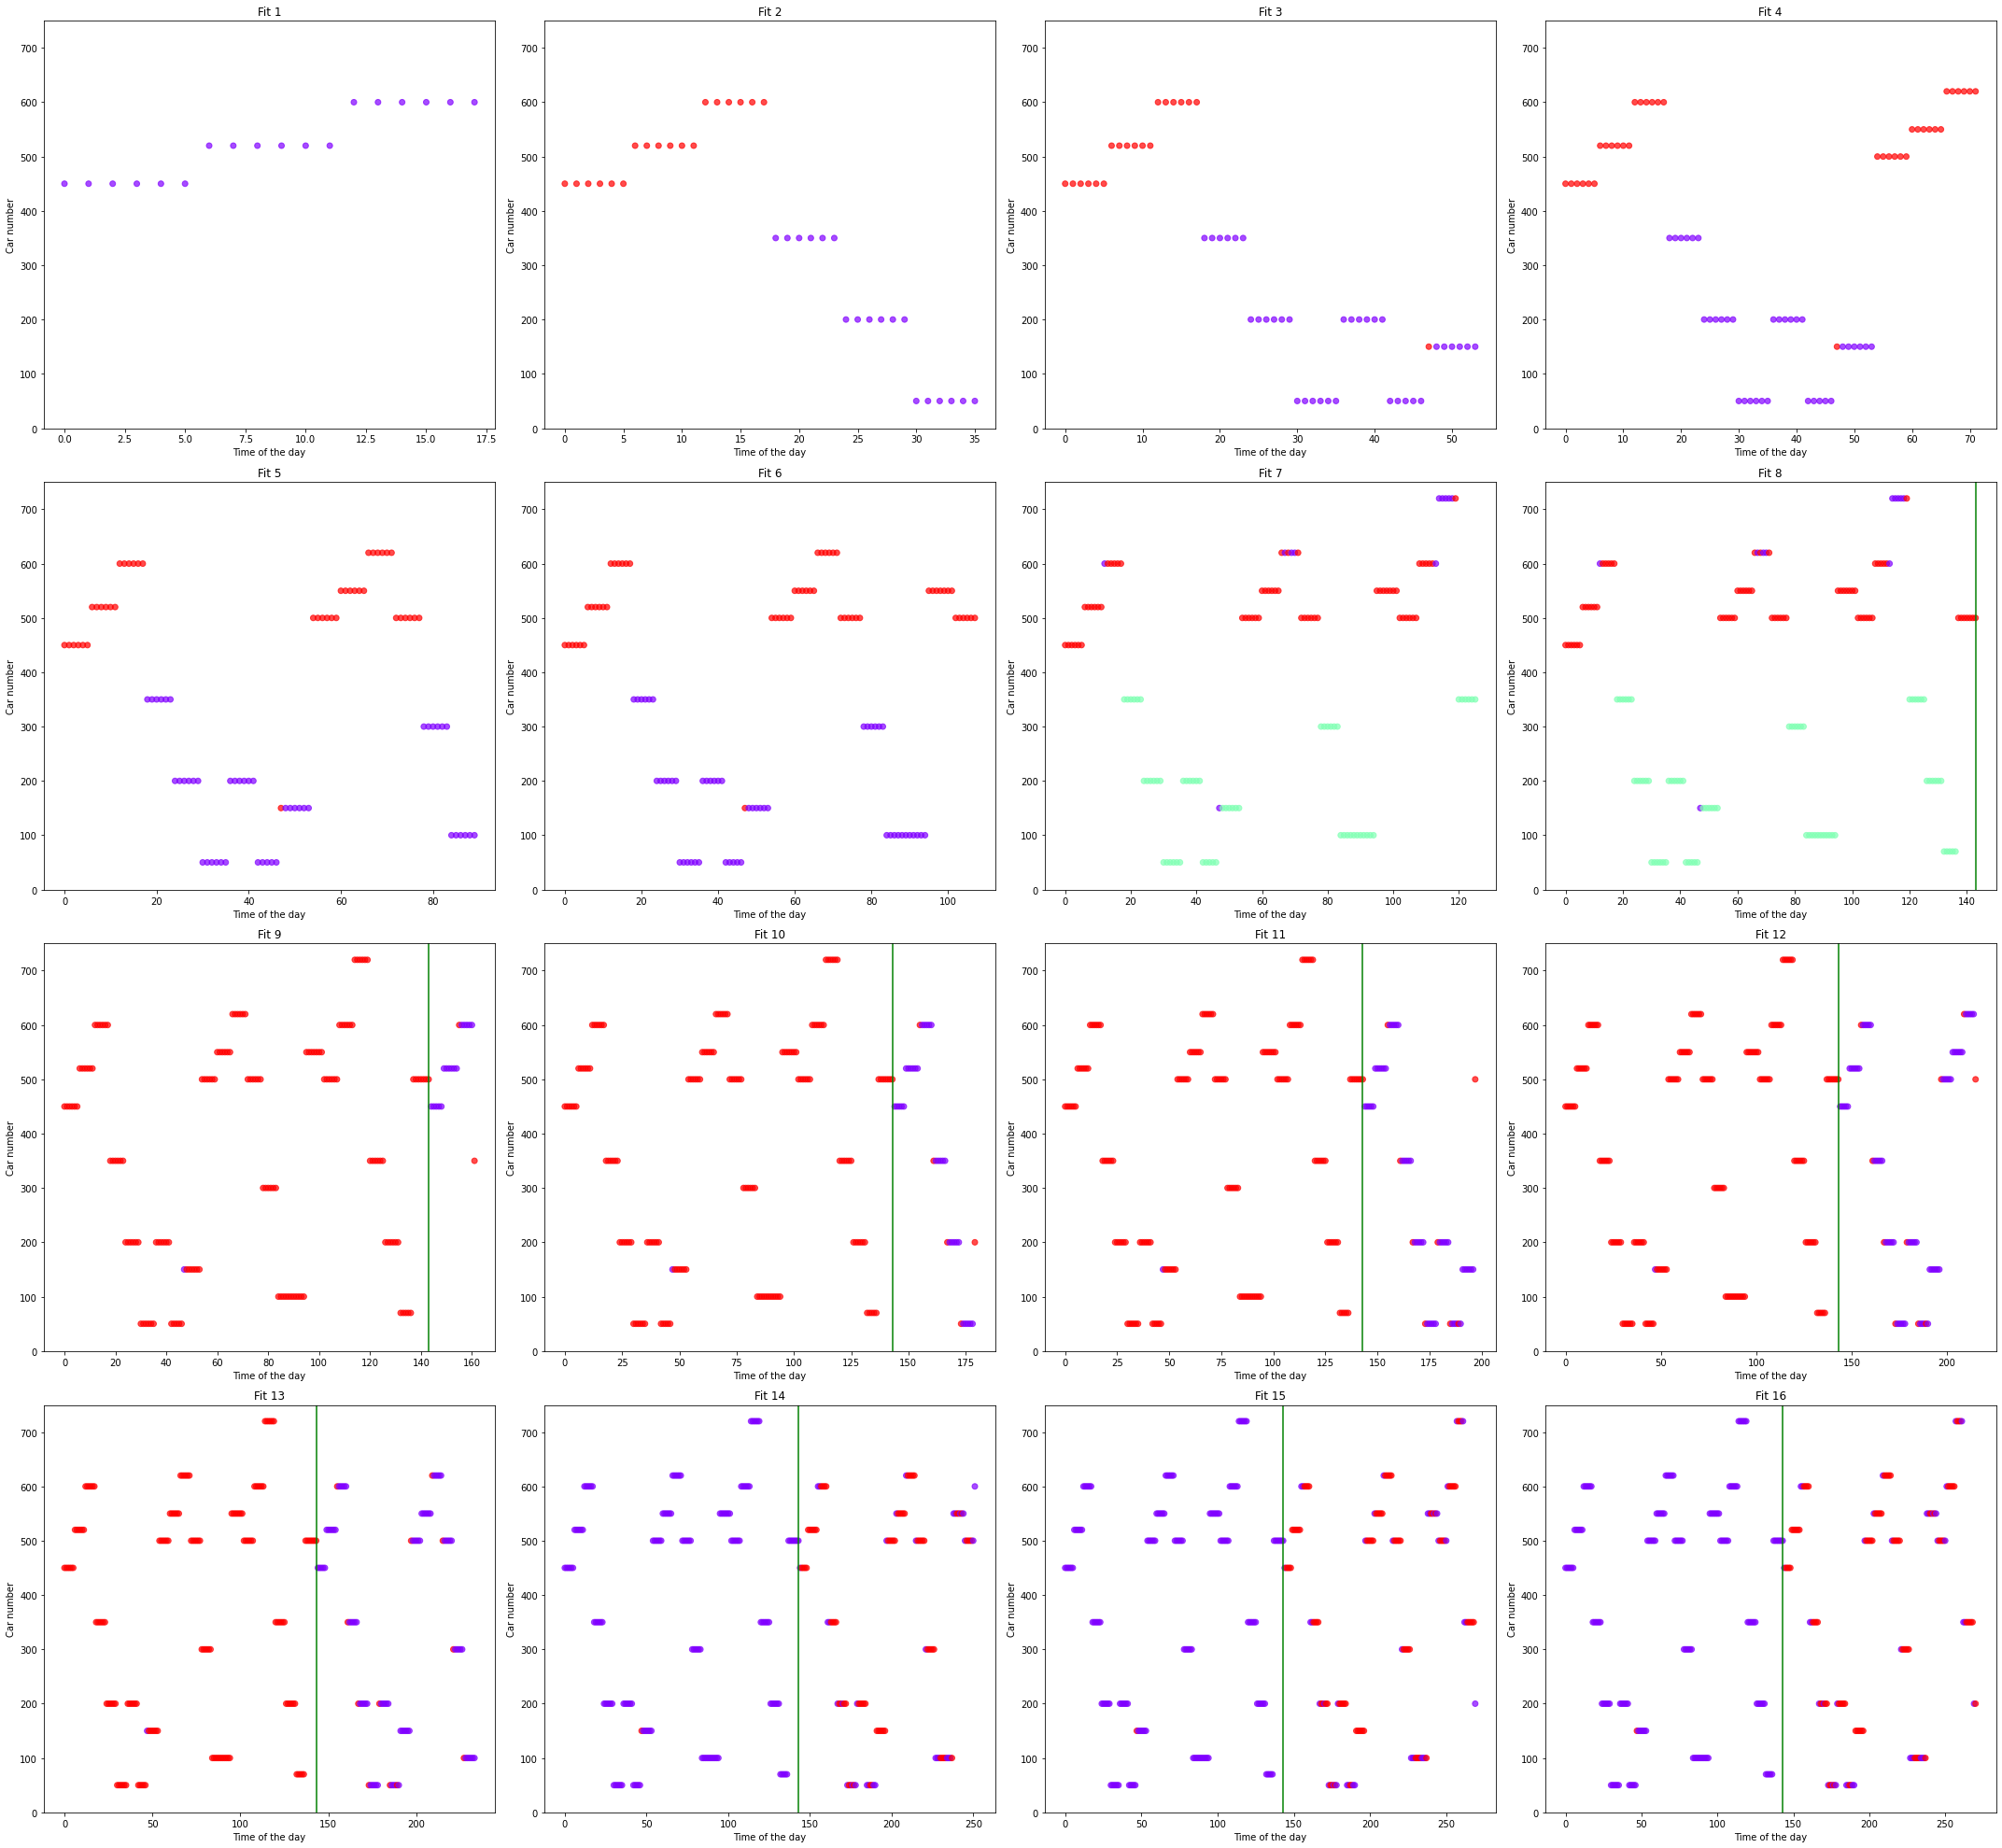

In [19]:
model_001_whole = Birch(n_clusters=None, threshold=0.3)
list_of_df_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

for i in list_of_dfs:
    add_data_to_this = pd.concat([add_data_to_this, i])
    
    numpy_array = outliers_removal(i)
    
    model_001_whole.partial_fit(numpy_array[:, :-2])
    model_copy = copy.deepcopy(model_001_whole)
    
    new_nmpy = add_data_to_this.to_numpy()

    n = plot_silhouette_scores(model_copy, new_nmpy[:, 3:7], 2, 10, f'fit{fit_number}')
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, 3:7])
    
    list_of_df_for_graphs.append(new_nmpy)
    fit_number += 1
    
    
col_counter = 0
row_counter = 0

nrows = 4
ncols = 4

fit_number = 1

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(30,30))

for i in list_of_df_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 0], i[:, 1], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
    if fit_number >= 8:
        axs[row_counter,col_counter].axvline(x=143, color='g')
    
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

Outliers detected: 0
couldnt get the scores, plz help
returning number of clusters = 2
Outliers detected: 0
couldnt get the scores, plz help
returning number of clusters = 2
Outliers detected: 2
couldnt get the scores, plz help
returning number of clusters = 2
Outliers detected: 0
couldnt get the scores, plz help
returning number of clusters = 2
Outliers detected: 0
couldnt get the scores, plz help
returning number of clusters = 2
Outliers detected: 5
couldnt get the scores, plz help
returning number of clusters = 2
Outliers detected: 0
The highest silhouette scores(0.5887230486927401) is for 2 clusers
Outliers detected: 1
The highest silhouette scores(0.6120601351346274) is for 2 clusers
Outliers detected: 2
The highest silhouette scores(0.9416997936421475) is for 2 clusers
Outliers detected: 2
The highest silhouette scores(0.9149487516444651) is for 2 clusers
Outliers detected: 4


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

The highest silhouette scores(0.8863577655188786) is for 2 clusers
Outliers detected: 2
The highest silhouette scores(0.7959000994060453) is for 3 clusers
Outliers detected: 3
The highest silhouette scores(0.7726045727508207) is for 3 clusers
Outliers detected: 0
The highest silhouette scores(0.7698047158268946) is for 2 clusers
Outliers detected: 4
The highest silhouette scores(0.7542557609985228) is for 2 clusers
Outliers detected: 0
The highest silhouette scores(0.8379740574892426) is for 2 clusers


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


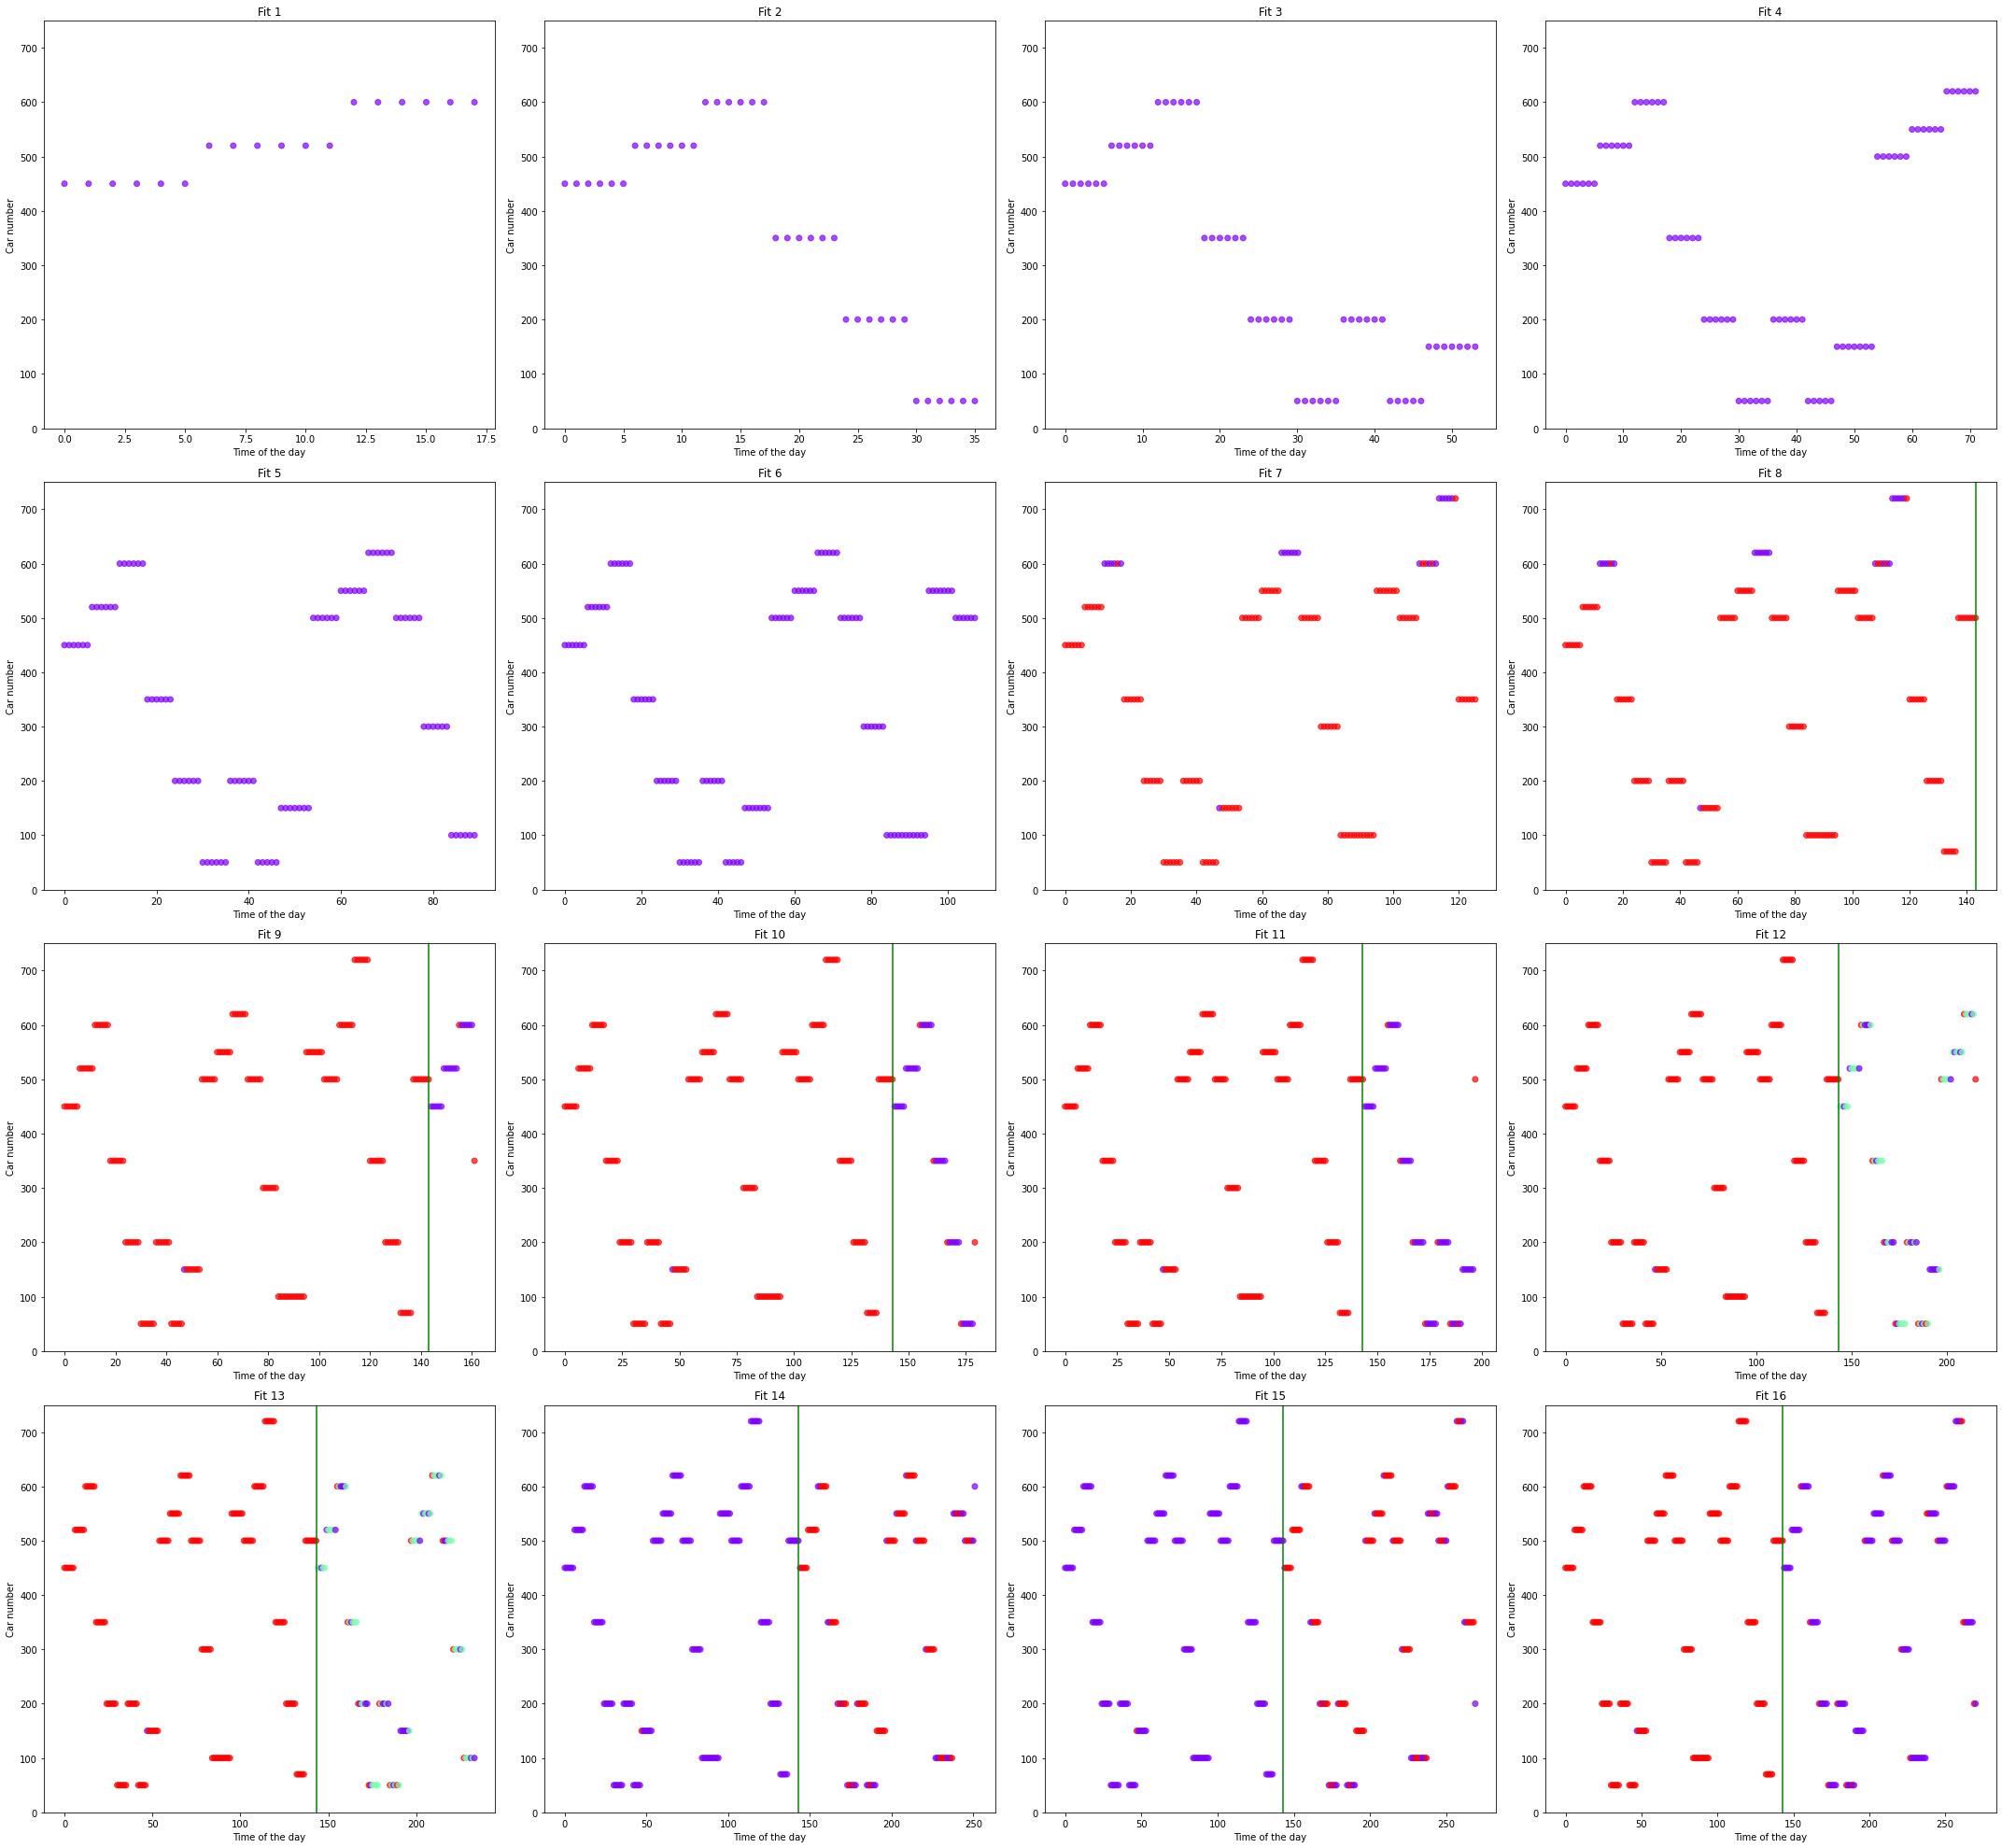

In [20]:
model_05_whole = Birch(n_clusters=None, threshold=0.5)
list_of_df_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

for i in list_of_dfs:
    add_data_to_this = pd.concat([add_data_to_this, i])
    
    numpy_array = outliers_removal(i)
    
    model_05_whole.partial_fit(numpy_array[:, :-2])
    model_copy = copy.deepcopy(model_05_whole)
    
    new_nmpy = add_data_to_this.to_numpy()

    n = plot_silhouette_scores(model_copy, new_nmpy[:, 3:7], 2, 10, f'fit{fit_number}')
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, 3:7])
    
    list_of_df_for_graphs.append(new_nmpy)
    fit_number += 1
    
    
col_counter = 0
row_counter = 0

nrows = 4
ncols = 4

fit_number = 1

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(30,30))

for i in list_of_df_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 0], i[:, 1], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
    if fit_number >= 8:
        axs[row_counter,col_counter].axvline(x=143, color='g')
    
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1